# Projet Python : reconnaissance de mélanomes 

Louise Blart & Jeanne Astier

## Introduction 

Les grains de beauté, ou *nævus mélanocytaire*, sont des tâches présentes sur la peau. La plupart des grains de beauté sont bénins ; mais certains peuvent évoluter en tumeurs malignes, dans 1 cas pour 100 000 environ. Ils s'agit alors de __mélanomes__, une forme de cancer de la peau.

Comme pour toutes les formes de cancer, un diagnostic précoce augmente l'efficacité du traitement : une mélanome détecté tôt peut être traité facilement, avant que la maladie n'évolue vers une forme mortelle. 

### Problématique

Comment la data science peut-elle aider à la reconnaissance des mélanomes ? 

Ce projet a vocation à __aider au diagnostic de mélanomes__ : nous voulons détecter, parmi un ensemble grains de beauté, lesquels sont malins et présentent un danger pour le patient. Pour ce faire, nous construisons sur algorithme de classification d'images distingant les grains de beauté "malins" et "bénins". 

NB : cette problématique a constitué l'objet d'un [challenge sur la plateforme Kaggle](https://www.kaggle.com/c/siim-isic-melanoma-classification), auquel ont participé plus de 3 000 équipes. Dans la mesure où nous sommes débutantes en machine learning, notre objectif n'est absolument pas de rivaliser avec tous ces participants : nous ne saurions prétendre concurrencer les gagnants d'un tel challenge en termes d'efficacité du diagnostic. Notre approche serait pluôt : comment, en partant de zéro en machine learning, peut-on essayer de traiter des images médicales pour y poser un diagnotic ?

### Plan

Notre projet se décompose en trois parties :
1. [Récupération et traitement des données](#1.-Récupération-et-traitement-des-données)
2. [Analyse de la base](#2.-Analyse-de-la-base)
3. [Modélisation et diagnostic](#3.-Modélisation-et-diagnostic)


### Préalable : téléchargement des modules

In [71]:
# Indiquez ici le chemin vers le dossier où se trouvent les modules téléchargés sur Github ( Recuperation_des_donnees , rapport, ...  )
path_files_modules = 'C:/Users/louis/OneDrive/Documents/ENSAE/2A/Info/Projet-Python-2A'

In [72]:
# modules classiques 
import numpy as np
import pandas as pd
import csv
import os 
import random
import sys

# modules créés pour ce projet 
sys.path.insert(0, path_files_modules)
import Recuperation_des_donnees as RD

# pour télécharger les données
import urllib.request
from zipfile import ZipFile

# pour la visualisation des données
import matplotlib.pyplot as plt

# modules de traitement d'images
import cv2  # Utiliser pip install opencv-python et redemarrer le noyau si besoin
import PIL

# modules de traitement du format DICOM
import pydicom as dicom  # Utiliser pip install pydicom et redemarrer le noyau si besoin
import pydicom.data
from pydicom.pixel_data_handlers.util import convert_color_space 

## 1. Récupération et traitement des données

Nous avons choisi d'effectuer ce projet sur le thème de la reconnaissance de mélanomes pour deux raisons : 
- il s'agit d'une forme de reconnaissance d'images médicales relativement accessible (plus accessible que le traitement d'images médicales comme des scanners ou des IRM par exemple) ;
- une large base d'images de grains de beauté est mise à disposition librement par la SIIM (*Society for Imaging Informatics in Medicine*) et l'ISIC (*International Skin Imaging Collaboration*). 

Le premier enjeu, et pas des moindres, est donc la récupération de ces données et leur traitement pour pouvoir ensuite les exploiter. 

### a) téléchargement des données

Les données sont disponibles [sur le site de l'ISIC](https://challenge2020.isic-archive.com/). Il s'agit de photos de grains de beauté, chacune étant accompagnée de métadonnées (âge et sexe du patient, partie du corps concerncée, etc.). Ces données sont disponibles sous plusieurs formats : 
- au format DICOM (*Digital Imaging and Communications in Medecine*) : il s'agit d'un format standard international pour la gestion informatique des données issues de l'imagerie medicale. Chaque fichier .dcm comprend une image et les métadonnées s'y rapportant. 
- aux formats JPG (pour les images) et CSV (pour les métadonnées) : ces formats sont également proposés par l'ISIC car plus facilement utilisables par le grand public. 

Nous avons fait le choix d'__utiliser des données au format DICOM__ et de les retraiter nous-mêmes pour les adapter à nos besoins. Nous souhaitons en effet inscrie ce projet dans une perspective médicale, en utilisant donc les données telles qu'elles se présentent en imagerie médicale.  


Création d'un dossier Projet_Melanomes comprenant : 
<li> ISIC_2020_Training_Dicom: base de données complete comprenant 33 106 images de grains de beauté avec leurs métadonnées associées</li>
<li> Diagnostic : fichier CSV complémentaire à la base ISIC_2020_Training_Dicom nous indiquant le diagnostic de chaque grain de beauté (bénin ou malin) </li>

In [7]:
RD.Premiere_fonction ()

 Répondez par 1 pour 'Oui' et 0 pour 'Non' à ce questionnaire 
Avez vous déja lancé ce programme ? (le dossier "Projet_Melanomes" contenant le fichier Base_complete (ISIC_2020_Training_Dicom dezippé) et le fichier Diagnostic est-il deja créé ?) [1 :"oui", 0: "non"] 1
Insérez le chemin du document 'Projet_Melanomes' (exemple : C:/Users/louis/OneDrive/Bureau/Projet_Melanomes) : C:/Users/louis/OneDrive/Bureau/Projet_Melanomes


In [73]:
# Chemin vers le dossier Projet_Melanomes créé à partir de la fonction ci-dessus
Path_Projet_Melanomes= RD.Path_Projet_Melanomes

### b) traitement des données

Maintenant que nous avons téléchargé toutes les données, nous pouvons commencer à les explorer - en particulier regarder comment se présente le format DICOM (format des images). 

In [74]:
# on choisit un fichier DICOM au hasard pour regarder sa structure 
path_dicom = Path_Projet_Melanomes+'/Base_complete/train'
files = os.listdir(path_dicom)
i = random.randint(0, len(files))
file = files[i]

In [75]:
# affichage des métadonnées associées à l'image
filename = pydicom.data.data_manager.get_files(path_dicom, file)[0]
ds = pydicom.dcmread(filename)
print(ds) 

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7748.6700.1589912760683.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 

On constate que les métadonnées sont très nombreuses ; mais seules quelques-unes nous intéressent : 

In [76]:
print("image :", file)
print("nom du patient :", ds.PatientName)
print("âge du patient :", ds.PatientAge)
print("sexe du patient :", ds.PatientSex)
print("prtie du corps : ", ds.BodyPartExamined)

image : ISIC_0299242.dcm
nom du patient : "ISIC^0299242"
âge du patient : 070Y
sexe du patient : F
prtie du corps :  TORSO


On peut enfin afficher l'image en tant que telle : 

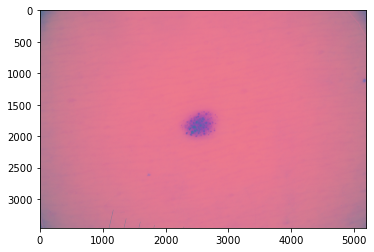

In [12]:
plt.imshow(ds.pixel_array) 

On constate que les couleurs de l'image n'ont pas l'air naturelles : il faut changer leur format de couleur pour avoir une aperçu des couleurs "naturelles" (format RGB). 
        

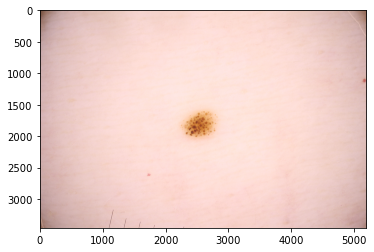

In [13]:
initial_color = ds.PhotometricInterpretation
convert = convert_color_space(ds.pixel_array, initial_color, 'RGB')
plt.imshow(convert)

Comme nous venons de le voir, le format DICOM peut être manipulé sur python à l'aide du module "pydicom". Cependant, ce format ne nous apparaît pas comme le plus facilement manipulable : nous préférons donc convertir ces données dans un format avec lequel nous sommes plus à l'aise. 

Deux étapes dans le traitement des données : 
- l'extraction des métadonnées de chaque fichier DICOM, pour les insérer dans un dataframe. 
- l'extraction des images de chaque fichier DICOM, pour les enregistrer au format JPG. 

Pour ce faire, nous avons créé une classe Dataframe dans le module Recuperation_des_donnees nous permettant d'extraire les métadonnées et de changer le format des images.

In [14]:
help(RD.Dataframe)

Help on class Dataframe in module Recuperation_des_donnees:

class Dataframe(builtins.object)
 |  Cette classe regroupe 3 fonctions : 
 |      - from_DICOM_to_DF : remplit un dataframe à partir des metadonnées DICOM
 |      - convert_DICOM_to_JPG : convertit une image DICOM en JPG
 |      - convert_to_JPG_RGB : convertit une image DICOM en JPG avec comme espace de couleurs le format RGB
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  convert_DICOM_to_JPG(self)
 |      Cette fonction permet de convertir un dossier dont les images sont sous
 |      le format DICOM en format JPG
 |      
 |      Cette fonction :
 |          - prend en parametres "self" permettant d'aller chercher les informations 
 |          dans la partie init
 |          - renvoie : Le dossier ou les images.jpg sont enregistrees  
 |          
 |      Exemple : 
 |          w = Dataframe()
 |          w.convert_DICOM_to_JPG()
 |  
 |

In [77]:
w=RD.Dataframe()
# Mise à jour de notre classe en fonction de nos chemins d'accès 
w.path_base_complete = Path_Projet_Melanomes+'/Base_complete/train'
w.path_Diagnostic= Path_Projet_Melanomes+'/Diagnostic.csv'

Nous traitons maintenant l'ensemble des fichiers DICOM téléchargés pour les insérer dans le dataframe des métadonnées. 

( __/!\ attention__ : là encore, la cellule suivant peut prendre plusieurs heures à tourner. Le programe doit en effet passer en revue quelques 33 106 fichiers pour en extraire des données, ce qui peut être un peu long).
Afin de limiter le temps de chargement, vous pouvez trouver ce fichier directement en format .csv sur le drive https://drive.google.com/drive/folders/1ByHZayDJD6OiB7g9D3hHsUMFWFZmeBy3?usp=sharing. 

In [5]:
df = w.from_DICOM_to_DF()
df.head(100)

NameError: name 'w' is not defined

Comme cette étape de création et de remplissage du datagrame complet est très très longue, nous préférons éviter de devoir la relancer à chaque nouvelle ouverture du projet ; aussi enregistrons-nous ce dataframe au format csv, pour pouvoir ensuite l'ouvrir plus facilement et rapidement. 

In [78]:
df.to_csv(Path_Projet_Melanomes+'/Base_complete.csv', index = False)

## 2. Analyse de la base

Nous allons maintenant analyser la base ainsi construite, et la représenter sous forme de graphiques pour se familiariser avec les données. 

Au préalable, nous téléchargeons les modules nécessaires :


In [79]:
#visualisation
import seaborn as sns

#Tests statistiques 
import scipy.stats as stats

Nous rehchargons la base à partir du CSV précédemment enregistré, pour éviter de devoir relancer le téléchargement de la base à chaque fois. 

In [80]:
df=pd.read_csv(Path_Projet_Melanomes+'/Base_complete.csv')
df.head()

,image_id,patient_age,patient_sex,body_part,image_name,target,patient_id
0,ISIC_0015719,40,F,UPPER EXTREMITY,ISIC_0015719,0,IP_3075186
1,ISIC_0052212,50,F,LOWER EXTREMITY,ISIC_0052212,0,IP_2842074
2,ISIC_0068279,45,F,HEAD/NECK,ISIC_0068279,0,IP_6890425
3,ISIC_0074268,55,F,UPPER EXTREMITY,ISIC_0074268,0,IP_8723313
4,ISIC_0074311,40,F,LOWER EXTREMITY,ISIC_0074311,0,IP_2950485


In [18]:
df.shape

(33012, 7)

On remarque que cette base est volumineuse : 33 126 lignes, c'est-à-dire 33 126 images de mélanomes (le nombre de patient peut être moindre : un même patient peut avoir plusieurs images de ménalomes). 

Par manque de puissance de calculs, nous ne sommes pas en mesure de traiter une telle base de données. C'est pourquoi nous souhaitons l'échantillonner avant de créer un algorithme de machin learning permettant d'identifier les mélanomes bénins et malins.
Comment selectionner notre échantillon ? 


In [19]:
df.isnull().sum()

image_id       0
patient_age    0
patient_sex    0
body_part      0
image_name     0
target         0
patient_id     0
dtype: int64

Cette commande permet d'identifier le nombre de valeurs manques. Il n'y en a ici que très peu : seulement 65 patients sur 33 126 ont omis de renseigner leur genre (valeur 'nan') et 49 patients ont renseigné 'X'. 
Les valeurs non-exploitables de la variable 'Patient_sex' représentent moins de 0,3% de notre échantillon, nous ne ferons donc pas d'étude sur les non réponses, et retirons ces patients de notre base de données. 


In [20]:
indexNames = df[ df['patient_sex']=='X'].index
df.drop(indexNames , inplace=True)
df.dropna(inplace=True)
# Enregistrement sur notre fichier.csv
df.to_csv(Path_Projet_Melanomes+'/Base_complete.csv', index = False)

### 1 - Analyses univariées

#### a) L'âge

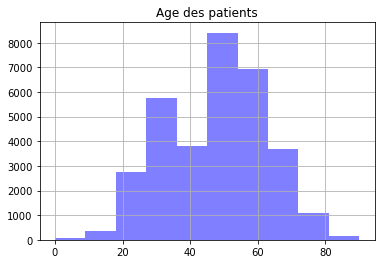

Moyenne : 46.87795347146492 
 Ecart type: 14.507820283196496


In [21]:
df['patient_age'].hist( facecolor='b', alpha=0.5)
plt.title('Age des patients')
plt.show()
print('Moyenne :', df['patient_age'].mean(), '\n', 'Ecart type:',  df['patient_age'].std())

#### b) Le sexe

In [22]:
df.groupby('patient_sex')['patient_id'].nunique()

patient_sex
F     976
M    1075
Name: patient_id, dtype: int64

Text(0.5, 0, ' Parité Hommes/Femmes')

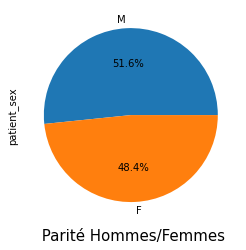

In [23]:
df["patient_sex"].value_counts().plot(kind='pie' , autopct='%1.1f%%')
plt.xlabel(' Parité Hommes/Femmes', fontsize=15)

La parité Homme/Femme est respectée. 

#### c) La partie du corps

In [24]:
df['body_part'].value_counts()

TORSO              16803
LOWER EXTREMITY     8382
UPPER EXTREMITY     4958
HEAD/NECK           1843
SKIN                 527
PALMS/SOLES          375
ORAL/GENITAL         124
Name: body_part, dtype: int64

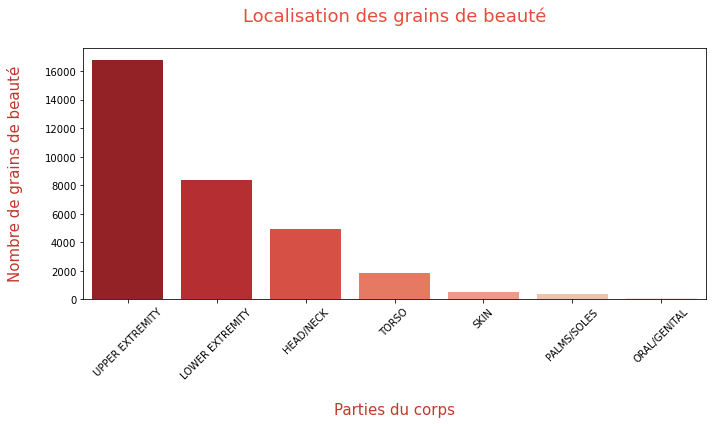

In [25]:
plt.figure(figsize=(10,6))
sns.barplot(x=df['body_part'].unique(), y=df['body_part'].value_counts(), palette="Reds_r")
plt.xlabel('\nParties du corps', fontsize=15, color='#c0392b')
plt.ylabel("Nombre de grains de beauté\n", fontsize=15, color='#c0392b')
plt.title("Localisation des grains de beauté\n", fontsize=18, color='#e74c3c')
plt.xticks(rotation= 45)
plt.tight_layout()

#### d) Melanomes bénins et malins

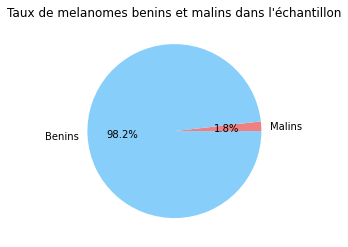

In [26]:
plt.pie([sum(df['target']==1),sum(df['target']==0)], labels = ['Malins','Benins'],colors = ['lightcoral','lightskyblue'],autopct='%1.1f%%')
plt.title("Taux de melanomes benins et malins dans l'échantillon")
plt.show()

#### e) Patients

In [27]:
print("nombre d'images :", df["image_id"].nunique())
print("nombre de patients :", df["patient_id"].nunique())

nombre d'images : 33012
nombre de patients : 2051


Il y a bien moins de patients que d'images (33126 images pour 2056 patients) : plusieurs images peuvent donc appartenir à un même patient (environ 16 images par patient en moyenne)

Text(0.5, 1.0, "nombre de mélanomes bénins et d'images pour les 20 patients ayant le plus de mélanomes bénins")

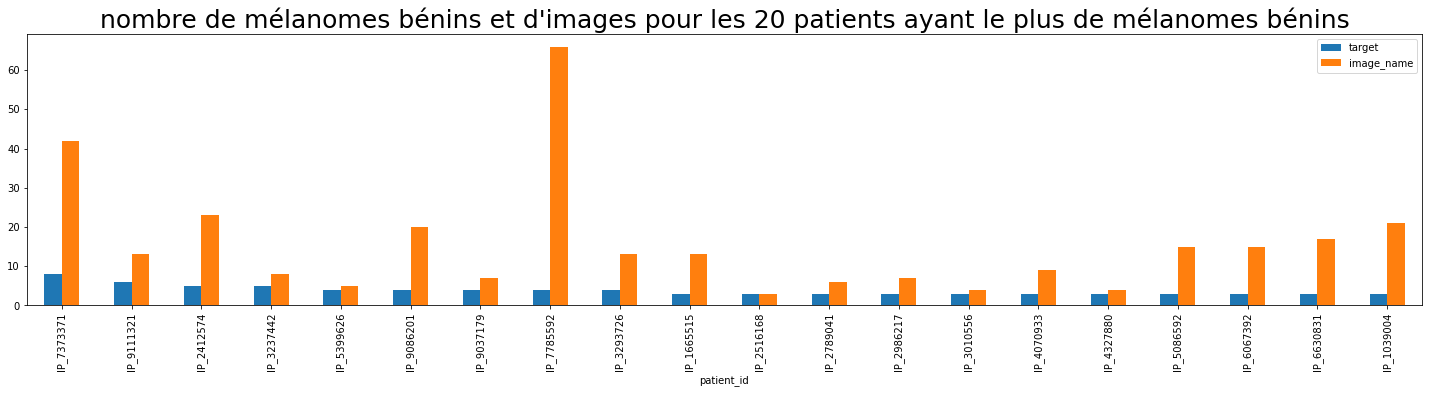

In [28]:
df1 = df.groupby("patient_id").sum()["target"]
df2 = df.groupby("patient_id").count()["image_name"]

pd.concat([df1, df2], axis=1, sort=False).sort_values(by = "image_name", ascending = False).head(150)

pd.concat([df1, df2], axis=1, sort=False).sort_values(by = "target", ascending = False).head(150)

pd.concat([df1, df2], axis=1, sort=False).sort_values(by = "target", ascending = False).head(20).plot(kind = "bar", figsize = (25,5))
plt.title("nombre de mélanomes bénins et d'images pour les 20 patients ayant le plus de mélanomes bénins", fontsize = 25)

Il y a jusqu'à 115 images par patient, et jusqu'à 8 mélanomes bénins par patient au sein de la base de donnée. Mais les patients qui ont le plus d'images ne sont pas nécessairement ceux qui ont le plus de mélanomes bénins

### 2 - Analyses bivariées

#### a) Les mélanomes et l'âge

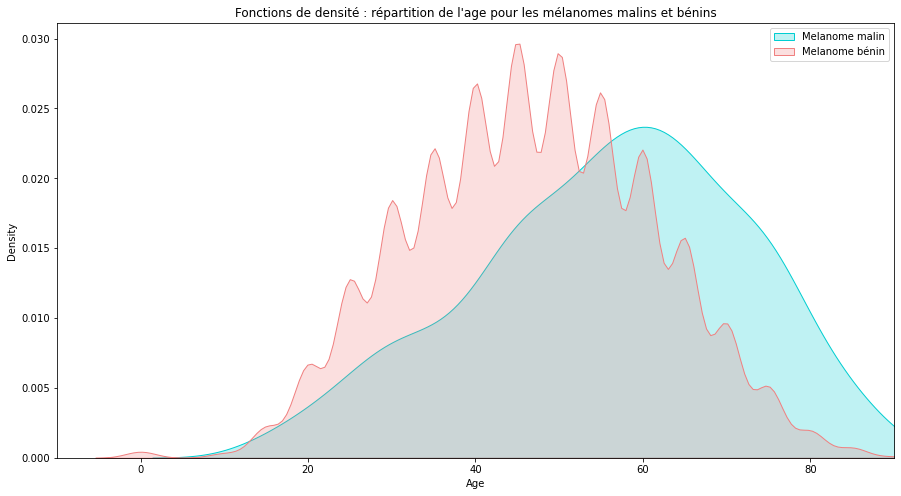

In [29]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(df["patient_age"][df.target == 1], color="darkturquoise", shade=True)
sns.kdeplot(df["patient_age"][df.target == 0], color="lightcoral", shade=True)
plt.legend(['Melanome malin', 'Melanome bénin'])
plt.title("Fonctions de densité : répartition de l'age pour les mélanomes malins et bénins")
ax.set(xlabel='Age')
plt.xlim(-10,90)
plt.show()

La distribution des mélanomes malins est décalée sur la droite par rapport à celle des bénins. Cela signifie que les personnes agées sont plus touchées par les mélanomes malins que les personnes jeunes. Les articles scientifiques confirment cette hypothèse. 


#### b) Melanomes et sexe

In [30]:
(df.groupby('patient_sex')['target'].sum() / df.groupby('patient_sex')['patient_id'].count() *100)

patient_sex
F    1.377669
M    2.135774
dtype: float64

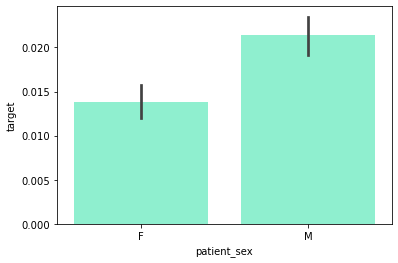

In [36]:
sns.barplot(x='patient_sex', y='target', data=df, color="aquamarine")
plt.show()

D'après cet échantillon les hommes sont plus touchés par les mélanomes malins que les femmes. 
1,37% des femmes de l'échantillon sont porteuses d'un mélanome bénins contre 2,13% des hommes.
Les articles scientifiques ne confirment pas cette hypothèse. 


In [32]:
print(stats.ttest_ind(df["target"][df.patient_sex == 'F'],df["target"][df.patient_sex == 'M']))

Ttest_indResult(statistic=-5.2236842264877605, pvalue=1.764609629122168e-07)


D'après les résultats du T-test, les populations féminines et masculines sont significativement différentes en ce qui concerne les mélanomes (p-value < 0,001)

#### c) Mélanomes et partie du corps

In [33]:
(df.groupby('body_part')['target'].sum() / df.groupby('body_part')['patient_id'].count() *100)

body_part
HEAD/NECK          4.015193
LOWER EXTREMITY    1.479361
ORAL/GENITAL       3.225806
PALMS/SOLES        1.333333
SKIN               1.707780
TORSO              1.529489
UPPER EXTREMITY    2.238806
dtype: float64

<AxesSubplot:xlabel='target', ylabel='body_part'>

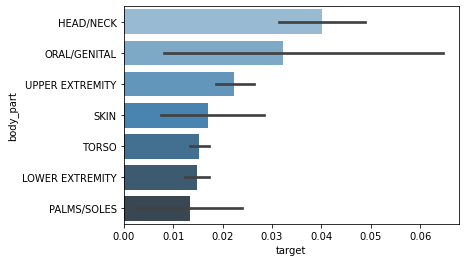

In [35]:
sns.barplot(x=df['target'], y=df['body_part'],palette='Blues_d', orient='h',  order=["HEAD/NECK", "ORAL/GENITAL","UPPER EXTREMITY","SKIN", "TORSO", "LOWER EXTREMITY", "PALMS/SOLES" ])

Le taux de mélanomes malins est plus élevé sur les parties du corps : 
- tête et cou
- orales et génitales 
- les membres supérieurs
      
Selon les articles scientifiques, les zones les plus exposées aux mélanomes malins sont les parties les plus exposées au soleil.
Il est donc raisonnable d'identifier la tête, le cou et les membres supérieurs dans les parties du corps les plus touchées par les mélanomes malins. 
Dans ce sens, cela est étonnant d'identifier les zones orales et génitales comme zones à risque. Cependant, dans notre échantillon, la catégorie "Oral/Genital" est la moins représentée des parties du corps; il n'y a que 124 images. Ce qui est très faible par rapport à notre base totale. L'échantillon est probablement peu représentatif de la population total pour cette partie du corps.


In [37]:
print(stats.kruskal(df["target"][df.body_part == 'HEAD/NECK'],df["target"][df.body_part == 'ORAL/GENITAL'],df["target"][df.body_part == 'SKIN'],df["target"][df.body_part == "UPPER EXTREMITY"],df["target"][df.body_part == "TORSO"],df["target"][df.body_part == "PALMS/SOLES"],df["target"][df.body_part == "LOWER EXTREMITY"]))

KruskalResult(statistic=71.33319858858539, pvalue=2.1778447508295032e-13)


D'après le test de Kruskal Wallis les populations de mélanomes sont différentes en fonction des parties du corps. 

### 3 - Régression linéaire logistique

La régression logistique est une technique prédictive. Elle vise à construire un modèle permettant de prédire / expliquer les valeurs prises par une variable cible qualitative (le plus souvent binaire, on parle alors de régression logistique binaire) à partir d’un ensemble de variables explicatives quantitatives ou qualitatives (un codage est nécessaire dans ce cas).
Nous voulons ici expliquer la variable 'target' (binaire) en fonction des variables 'patient_age'(quantitative), 'patient_sex'(qualitative), 'body_part'(qualitative). 


In [66]:
training=pd.get_dummies(df, columns=["patient_sex","body_part"])

# On retire la variable patient_sex_F, qui est parfaitement colinéaire à patient_sex_M
training.drop('patient_sex_F', axis=1, inplace=True) 
final_train = training
final_train.head()

,image_id,patient_age,image_name,target,patient_id,patient_sex_M,body_part_HEAD/NECK,body_part_LOWER EXTREMITY,body_part_ORAL/GENITAL,body_part_PALMS/SOLES,body_part_SKIN,body_part_TORSO,body_part_UPPER EXTREMITY
0,ISIC_0015719,40,ISIC_0015719,0,IP_3075186,0,0,0,0,0,0,0,1
1,ISIC_0052212,50,ISIC_0052212,0,IP_2842074,0,0,1,0,0,0,0,0
2,ISIC_0068279,45,ISIC_0068279,0,IP_6890425,0,1,0,0,0,0,0,0
3,ISIC_0074268,55,ISIC_0074268,0,IP_8723313,0,0,0,0,0,0,0,1
4,ISIC_0074311,40,ISIC_0074311,0,IP_2950485,0,0,1,0,0,0,0,0


In [67]:
import statsmodels.api as sm
from sklearn import linear_model

In [68]:
X = final_train[["patient_age", "patient_sex_M", "body_part_HEAD/NECK", "body_part_LOWER EXTREMITY", 
              "body_part_ORAL/GENITAL","body_part_PALMS/SOLES","body_part_SKIN", "body_part_TORSO", "body_part_UPPER EXTREMITY"]]
X = sm.add_constant(X) # une autre façons d'ajouter une constante
y = final_train["target"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     39.30
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           7.12e-63
Time:                        18:53:32   Log-Likelihood:                 20206.
No. Observations:               33012   AIC:                        -4.039e+04
Df Residuals:                   33003   BIC:                        -4.032e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

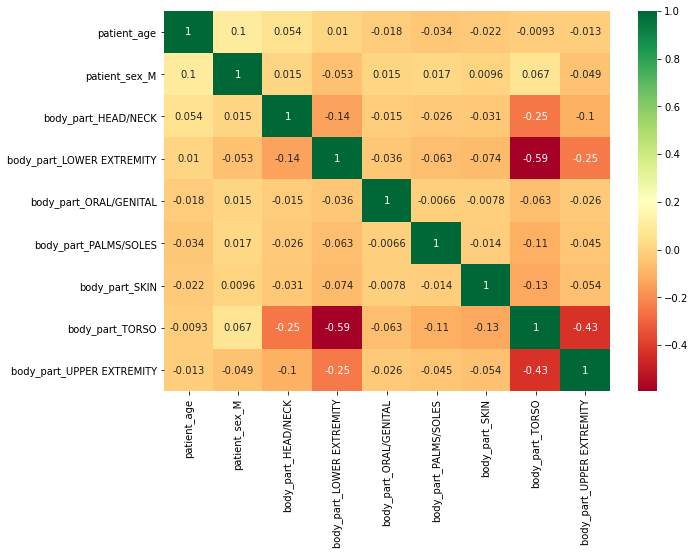

In [69]:
Selected_features = ["patient_age", "patient_sex_M", "body_part_HEAD/NECK", "body_part_LOWER EXTREMITY", 
              "body_part_ORAL/GENITAL","body_part_PALMS/SOLES","body_part_SKIN", "body_part_TORSO", "body_part_UPPER EXTREMITY"]
X = final_train[Selected_features]

plt.subplots(figsize=(10, 7))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

Notre modéle n'est pas convainquant, les coefficients sont très faibles, les variables age, parties du corps et sexe expliquent à hauteur de 0,9% les mélanomes malin (R²=0,009).
Il n'est pas possible d'expliquer convenablement les mélanomes malins à partir de ces variables explicatives.
Il est donc primordial d'analyser les images de mélanomes afin de fournir un modèle prédictif acceptable. 


## 3. Modélisation et diagnostic

Projet : essayer de reproduire / adapter ça https://www.kaggle.com/kkhandekar/image-classification-for-beginners-cnn-keras

import des packages 


In [82]:
# Module créé pour ce projet 
import Echantillonnage

# package machine learning
import sklearn 

#package TensorFlow (pour le CNN)
#import tensorflow as tf    

import shutil

### 1 - Création des bases train et test

On veut constituer une base d'entraînement (train) et une base de test à partir de l'ensemble des images (plus de 33 000). 
Cette base de donnée est représentée par le Dataframe "df" importé précedemment. 

Calcul du taux de mélanomes malins au sein de cette base :

In [83]:
t = sum(df['target']==1) / len(df.index)
print("taux de malignité des mélanomes :", t*100, "%")

taux de malignité des mélanomes : 1.769053677450624 %


Comme nous l'avions déjà vu, le taux de malignité des mélanomes est très faible (1,76%).

Aussi, dans un premier temps, pour faciliter la construction de premiers modèles, nous construisons une base réduite avec un taux de malignité supérieur. Nous réduisons ainsi le nombre total d'images, ce qui nous permettra aussi de construire des modèles plus économes en mémoire vive pour l'instant. C'est à partir de cette base réduite que nous constitueront les bases test et train. 

#### a) échantillonnage 

Pour ce faire, on commence par définir une fonction d'échantillonnage simple dans notre module Echantillonnage : 

In [84]:
help(Echantillonnage.simple_sampling)

Help on function simple_sampling in module Echantillonnage:

simple_sampling(df, size, malignancy_rate)
    Cette fonction crée un échantillon simple de taille fixée avec un taux de malignité fixé à partir d'un dataframe. 
    Les lignes sélectionnées dans l'échantillon sont tirées aléatoirement, de manière équiprobable. 
        
        Cette fonction :
            - prend en paramètres :
                - df : le dataframe à partir duquel on souhaite construire l'échantillon
                - size : la taille de l'échantillon   
                - malignancy_rate : le taux d'images représentant des grains de beauté malins au sein de l'échantillon
            - renvoie : l'échantillon ainsi construit
            
        Exemple : 
            df = df
            size = 100
            malignancy_rate = 0,2
            => renvoie un dataframe de 100 lignes sélectionnées aléatoirement dans df dont 20% représentent des 
            mélanomes (malins), 80% des grains de beauté bénins.



Dans un premier temps, nous choisissons d'extraire un échantillon de 600 images dont 20% représentent des grains de beauté malins (mélanomes) ; ces paramètres pourront être amenés à varier. 

In [85]:
size = 1000
malignancy_rate = 0.5
df_sample = Echantillonnage.simple_sampling(df, size, malignancy_rate)
df_sample

,image_id,patient_age,patient_sex,body_part,image_name,target,patient_id
233,ISIC_0188432,50,F,UPPER EXTREMITY,ISIC_0188432,1,IP_0135517
312,ISIC_0207268,55,M,TORSO,ISIC_0207268,1,IP_7735373
396,ISIC_0232101,60,M,TORSO,ISIC_0232101,1,IP_8349964
456,ISIC_0247330,65,F,LOWER EXTREMITY,ISIC_0247330,1,IP_3232631
541,ISIC_0272509,30,F,LOWER EXTREMITY,ISIC_0272509,1,IP_0408084
...,...,...,...,...,...,...,...
32626,ISIC_9882759,60,M,LOWER EXTREMITY,ISIC_9882759,0,IP_6512345
32627,ISIC_9883092,75,M,TORSO,ISIC_9883092,0,IP_4294140
32680,ISIC_9895881,60,M,UPPER EXTREMITY,ISIC_9895881,0,IP_1348848
32809,ISIC_9937653,30,M,HEAD/NECK,ISIC_9937653,0,IP_6945048


On sauvegarde l'échantillon ainsi construit dans un CSV (au cas où)

In [86]:
df_sample.to_csv(Path_Projet_Melanomes+'/Sample.csv')

#### b) train / test split

Pour diviser cet échantillon en train et test, on s'appuie sur le package scikit-learn. 

Pour l'instant, on choisit arbitrairement d'allouer 20% de notre échantillon au test et 80% au test - proportions que l'on pourra changer par la suite. 

In [87]:
from sklearn.model_selection import train_test_split

X = df_sample["image_id"]
Y = df_sample["target"]

In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

### 2- Définition des classes et import des données

définition des classes (deux seulement : bénin et malin)

In [89]:
class_names = ['benin', 'malin']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [90]:
class_names_label

{'benin': 0, 'malin': 1}

In [91]:
image_size = (150, 150) 
# je mets ça mais on peut modifier
# attention quand même : si on modifie, il faut modifier les paramètres du modèle qui sont adaptés au format d'image

In [92]:
#création d'un dossier avec les images DICOM de la base train

path_dicom_sample_train = Path_Projet_Melanomes+'/Dicom_Sample_Train'  

for file in X_train :
    shutil.copy(w.path_base_complete + '/' + file +'.dcm', path_dicom_sample_train + '/' + file +'.dcm')

In [93]:
#création d'un dossier avec les images DICOM de la base test
path_dicom_sample_test =  Path_Projet_Melanomes+'/Dicom_Sample_Test' 

for file in X_test :
    shutil.copy(w.path_base_complete + '/' + file +'.dcm', path_dicom_sample_test + '/' + file +'.dcm')

In [94]:
#conversion des images train en jpg - attention cette fonction est longue à exécuter (plusieurs dizaines de minutes)
w.path_base_complete = path_dicom_sample_train
w.path_jpg_RGB=Path_Projet_Melanomes+'/JPG_Sample_Train' 
w.convert_to_JPG_RGB()

Le dossier est pret !


In [95]:
#conversion des images test en jpg - attention cette fonction est longue à exécuter (plusieurs dizaines de minutes)
w.path_base_complete = path_dicom_sample_test
w.path_jpg_RGB=Path_Projet_Melanomes+'/JPG_Sample_Test' 
w.convert_to_JPG_RGB()

Le dossier est pret !


Il faut ensuite charger les données pour pourvoir les insérer dans le modèle ; pour ce faire, on crée la fonction load_data qui télécharge les images et leurs labels :

In [59]:
def load_data():
    
    path_jpg_train = Path_Projet_Melanomes+'/JPG_Sample_Train' 
    path_jpg_test = Path_Projet_Melanomes+'/JPG_Sample_Test' 
    
    meta_data = df_sample
    meta_data = meta_data.set_index("image_id")
    datasets = [path_jpg_train, path_jpg_test]
    
    output = []
    
    #itération sur chaque dataset (train puis test)
    for dataset in datasets :
         
        images = []
        labels = []        
            
        # itération sur chaque image du dataset
        for file in os.listdir(dataset) :
                
            # obtention du le chemin de l'image
            img_path = os.path.join(dataset, file)
            
            # obtention du label de l'image 
            label = meta_data.loc[file[0:12]].target
                
            # ouverture de l'image et retraitement de l'image (changement de couleurs et réduction de taille)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, image_size) 
                
            # ajout de l'image et de son label à la liste de résultats
            images.append(image)
            labels.append(label)
    
        # conversion des images et des labels en valeurs numériques
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')  
        
        output.append((images, labels))
        
    return output

chargement des données (attention, cette cellule prend un peu de temps à exécuter, de l'ordre de quelques minutes)

In [60]:
(train_images, train_labels), (test_images, test_labels) = load_data()

on mélanges les données de la base test pour ne plus avoir les malins en haut et les bénins en bas

In [61]:
train_images, train_labels = sklearn.utils.shuffle(train_images, train_labels, random_state=25)

### 3 - Visualisation des données et preprocessing


Exploration de l'échantillon de données

In [62]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("nombre d'images dans la base train :", n_train)
print ("nombre d'images dans la base test :", n_test)
print ("taille de chaque image :", image_size)

nombre d'images dans la base train : 480
nombre d'images dans la base test : 120
taille de chaque image : (150, 150)


Ici on peut faire une exploration détaillée des bases train et test en les comparant entre elles et avec la base complète (sans doute en reprenant et adaptant la partie "analyse de la base"). 

Je ne le fais pas pour l'instant car je suis trop impatiente d'arriver à la partie "modèle" pour avoir les premiers résultats, mais il faudra revenir dessus plus tard.

Par ailleurs, j'ai l'impression que le notebook que je prends comme exemple ne fait quasiment rien comme preprocessing des images - sans doute parce que c'est une version pour débutants. Je poursuis donc en faisant comme l'exemple, mais je pense qu'il faudra ici qu'on ajoute pas mal de choses (j'ai par exemple trouvé ça : https://towardsdatascience.com/data-preprocessing-and-network-building-in-cnn-15624ef3a28b)

In [64]:
#Scale the data
train_images = train_images / 255.0
test_images = test_images / 255.0
# d'où sort le 255 ?? mystère et boule de gomme

Visualisation d'exemples d'images de la base, pour en avoir un aperçu : 

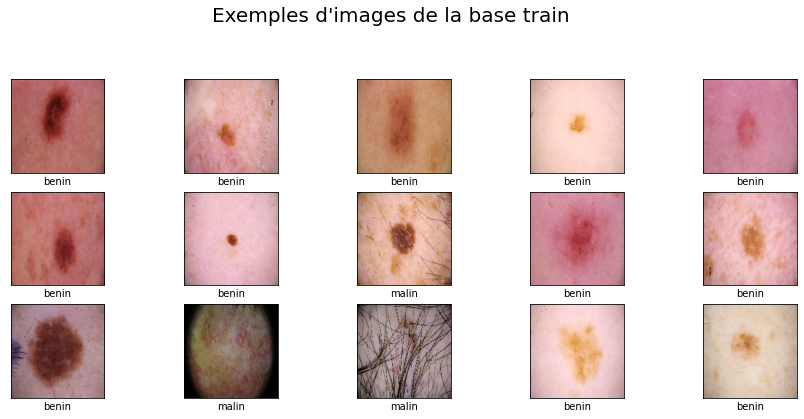

In [65]:
def display_examples(class_names, images, labels):
   
    fig = plt.figure(figsize=(15,10))
    fig.suptitle("Exemples d'images de la base train", fontsize=20)
    for i in range(15):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.show()

display_examples(class_names, train_images, train_labels)

### 4 - Modèle de CNN simple

Un réseau de neurones convolutifs est un système composé de neurones, généralement répartis en plusieurs couches connectées entre elles. Nous l'utilison ici pour résoudre un problème de classification. Le réseau calcule à partir de l'entrée une probabilité pour chaque classe. 
Chaque couche reçoit en entrée des données et les renvoie transformée. Pour cela, elle calcule une combinaison linéaire puis applique éventuellement une fonction non-linéaire, appelée fonction d'activation. Les coefficients de la combinaison linéaire définissent les paramètres (ou poids) de la couche.
Un réseau de neurones est construit en empilant les couches : la sortie d'une couche correspond à l'entrée de la suivante.
La dernière couche calcule les probabilités finales en utilisant pour fonction d'activation la fonction logistique (pour une classification binaire).
Une fonction de perte (loss function) est associée à la couche finale pour calculer l'erreur de classification.   
N'ayant pas encore fait de cours de Machine Learning à l'ENSAE, nous nous sommes basées sur les ressources suivantes :    
<li> cours openclassrooms Classez et segmentez des données visuelles : https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles</li>
<li> https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/</li>

Les CNN réalisent eux-mêmes le travail fastidieux d'extraction et de description de features, cela constitue une des forces des réseaux de neurones convolutifs : plus besoin d'implémenter un algorithme d'extraction "à la main", comme SIFT ou Harris-Stephens. 
Comme nous l'avons vu précédemment, un reseau de neurones est constitué de plusieurs couches. Il existe quatre types de couches pour un réseau de neurones convolutif : 
<p>
<li>la couche de convolution,</li> 
<li> la couche de pooling, </li> 
<li> la couche de correction ReLU, </li> 
<li> la couche fully-connected.</li> 
</p>

#### a) construction du modèle

In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])
 
# Dans la couche conv2D je pense qu'il faut mettre (5,5) et non (3,3) pour la 1e couche car on a des images de taille supérieur à 128x128
# Dans les couches conv2D en dessous il faut je pense réduire à (3,3), comme il y a eu un pooling
# On pourra aussi automatiser le input_shape après, ce sera plus simple si on veut regarder pour différentes tailles 
# Entre autre pour diminuer les dimensions d'images j'avais fait une fonction qui réduit en fonction d'un ratio puisque 
#  nos images de départ ne sont pas carrés et donc pour ne pas les déformer en passant de rectangle à carré. (mais on verra plus tard)
# Dans la couche Dense je crois qu'il faut bien mettre 128 car la couche conv2 juste avant est de 128
# Par contre dans la derniere couche Dense je crois qu'il faut mettre 2 et pas 6 car on a que 2 catégories différentes ( mais je suis pas sure)
#  Toujours dans les deux couches dense, parametre activation: je crois aussi qu'il faut mettre la relu dans la 1e et la softmax dans la 2 mais je sais pas pourquoi

model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),    
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),   
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])


NameError: name 'tf' is not defined

**Commentaire**


Fonctions que l'on pourrait ajouter :

model.add(BatchNormalization()) : La normalisation par lots permet des taux d'apprentissage beaucoup plus élevés. L'initialisation des pondérations peut être difficile, en particulier lors de la création de réseaux profonds. La normalisation par lots permet de réduire la sensibilité aux poids de départ initiaux. Pour augmenter les performances de notre modele, la normalisation est placée juste apres la couche de correction.

model.add(Dropout(p)) : avec le paramatre p a définir. Cette fonction permet d'abandonner certains neurones avec probabilité p. 

In [1]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

# Ici je crois plutot qu'il faut mettre ça : model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy','binary_crossentropy'])
# car on est dans un modele binaire

NameError: name 'model' is not defined

#### b) Explications du modèle : 

**La couche de convolution** constitue toujours au moins la première couche d'un CNN.Son but est de repérer la présence d'un ensemble de features dans les images reçues en entrée. La couche de convolution reçoit donc en entrée plusieurs images, et calcule la convolution de chacune d'entre elles avec chaque filtre. Les filtres correspondent exactement aux features que l'on souhaite retrouver dans les images. 


*tensorflow.keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)*

   
<p>
<li> Conv2D : pour les images, Conv1D: dimension 1, Conv3D: pour les volumes </li> 
<li> Filters (32) : Nombre de filtres a apprendre : commencer par un nombre de filtre assez faible (32) et augmenter dans les couches suivantes dans l'idéal des multiples de 2, on peut apprendre dans les premières couches 32, 64, 128 filtres puis aller jusqu'à 256, 512, 1024 dans les couches plus pronfondes. </li> 
<li> kernel_size (5,5) : dimension du kernel, si on a des images jusqu'à 128x128 on va utiliser 3x3. Au dessus on utilisera 5x5 ou 7x7. Il faudra dans les couches suivantes se reduire à du 3x3. </li> 
<li> strides : pas avec lequel on va analyser l'image pixel par pixel. La valeur par défaut est (1, 1); cependant, on peut parfois l'augmenter à (2, 2) pour aider à réduire la taille du volume de sortie.  </li> 
<li> Padding : Il peut prendre deux paramétres "valide" ou "same". Avec le paramètre valide, le volume d'entrée n'est pas rempli de zéro et les dimensions spatiales peuvent être réduites via l'application naturelle de la convolution. On preferera reduire les dimensions spaciales avec le max pooling ou la strided convolution. On notera padding = 'same' pour la majorité de nos couches. </li> 
<li> data_format: Height, Width, Depth </li>
<li> dilation_rate : On utilise ce parametre de dilatation quand on travaille avec des images de plus haute résolution (où les détails sont importants) ou quand on construit un réseau avec moins de paramètres. </li>
<li> activation : Nom de la fonction d'activation que l'on souhaite appliquer après avoir effectué la convolution. Elle constitue la couche d'activation. On utilisera ici la fonction 'relu' qui est très utilisée dans les CNN. Elle permet un apprentissage plus rapide de notre modéle.  </li>
<li> use_bias : Contrôle si un vecteur de biais est ajouté à la couche de convolution. Recommandé de garder le biais sauf dans des cas particuliers.</li>
<li> kernel_initializer :contrôle la méthode d'initialisation utilisée pour initialiser toutes les valeurs avant d'entraîner réellement le réseau. Recommandé de ne pas y toucher sauf si réseau très profond</li>
<li> bias_initializer : contrôle la façon dont le vecteur de biais est initialisé avant le début de l'entraînement. Recommandé de ne pas y toucher</li>
<li> kernel_regularizer, bias_regularizer, activity_regularizer : controle le type de regularisation. Recommandé de ne pas changer les valeurs par défaut.  </li>
<li> kernel_constraint,  bias_constraint : Ces paramètres permettent d'imposer des contraintes sur la couche Conv2D (ex : non-négativité, la normalisation d'unité et la normalisation min-max ... ). Il est recommandé de laisser les valeur par defaut.</li>
</p>

**La couche de pooling :** Cette couche est souvent placé entre deux couches de convolution : elle reçoit en entrée plusieurs feature maps, et applique à chacune d'entre elles l'opération de pooling. L'opération de pooling consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes. La couche de pooling permet de réduire le nombre de paramètres et de calculs dans le réseau. On améliore ainsi l'efficacité du réseau et on évite le sur-apprentissage.


*tf.keras.layers.MaxPooling2D ( pool_size=(2, 2), strides=None, padding="valid", data_format=None)*

<p>
<li> pool_size : facteur de réduction d'échelle (vertical, horizontal). (2, 2) réduira de moitié l'entrée dans les deux dimensions spatiales.</li>
    <li> Strides,  Padding et data_format ont la même signification que dans la couche de convolution. S'ils ne sont pas précisés dans la fonction de MaxPooling2D, ils prendont les mêmes valeurs que dans la couche de convolution. </li>
</p>

**La couche de correction :** 

La couche de correction ReLU remplace toutes les valeurs négatives reçues en entrées par des zéros. Elle joue le rôle de fonction d'activation. Elle est appliquée dans la couche de convolution de notre modèle :  activation = 'relu'. La fonction 'relu' est très utilisée dans les CNN. Elle permet un apprentissage plus rapide de notre modéle.

Ces deux commandes sont les mêmes :

 - model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3))
 
 - model.add(layers.Conv2D(32, (3, 3), input_shape = (150, 150, 3))       
 model.add(layers.Activation(activations.relu)) </li>


**La couche fully-connected**

La couche fully-connected constitue toujours la dernière couche d'un réseau de neurones, convolutif ou non – elle n'est donc pas caractéristique d'un CNN. 
Ce type de couche reçoit un vecteur en entrée et produit un nouveau vecteur en sortie. Pour cela, elle applique une combinaison linéaire puis éventuellement une fonction d'activation aux valeurs reçues en entrée.
La dernière couche fully-connected permet de classifier l'image en entrée du réseau : ici elle renvoie un vecteur de taille 2 ( pour une classification binaire). Chaque élément du vecteur indique la probabilité pour l'image en entrée d'appartenir à une classe (malin ou bénin). 

La fonction flatten : Elle permet de convertir des matrices 3D en vecteur 1D.

La fonciton Dense :     
*tf.keras.layers.Dense( units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)*
<p>
    <li> Units :Entier positif précisant la taille du vecteur en sortie</li>
    <li> Activation : indique si une correction ReLU ou softmax est effectuée juste après la couche fully-connected </li>
    <li> Les autres paramétres ont la même description que dans la couche de convolution </li>
</p>

**Compilation du modéle :**

Avant d’entraîner notre modèle, nous devons configurer le processus d’apprentissage en appelant la méthode compile() de Keras.

*compile( optimizer, loss = None, metrics = None, loss_weights = None, sample_weight_mode = None, weighted_metrics = None, target_tensors = None )*

<p>
    <li>optimizer : optimise les poids d'entrée en comparant la fonction de prédiction et de perte. Keras fournit plusieurs optimiseurs sous forme de module. Pour un probleme de classification binaire on utilisera 'rmsprop'</li>

<li>loss : Il s’agit de la fonction de coût que le modèle va utiliser pour minimiser les erreurs. On utilisera loss='binary_crossentropy' pour une classification binaire,</li>

<li> metrics : En machine learning, les métriques sont utilisées pour évaluer les performances du modèle. Il est similaire à la fonction de perte, mais n'est pas utilisé dans le processus de formation. Keras fournit plusieurs métriques sous forme de module. Dans le cas d'un probleme de classification on utilise metrics = ['accuracy']</li>

<li> loss_weights, sample_weight_mode, weighted_metrics, target_tensors : Parametres de pondération facultatifs. Nous garderons ces parametres à leur valeur par défaut.   </li>

#### c) training

In [78]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
3/3 [==============================] - 5s 2s/step - loss: 0.9248 - accuracy: 0.5677 - val_loss: 0.5328 - val_accuracy: 0.8021
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 0.4577 - accuracy: 0.8047 - val_loss: 0.5512 - val_accuracy: 0.8021
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 0.4683 - accuracy: 0.8151 - val_loss: 0.4671 - val_accuracy: 0.7500
Epoch 4/20
3/3 [==============================] - 3s 1s/step - loss: 0.4429 - accuracy: 0.8125 - val_loss: 0.4569 - val_accuracy: 0.8021
Epoch 5/20
3/3 [==============================] - 3s 1s/step - loss: 0.4030 - accuracy: 0.8229 - val_loss: 0.4410 - val_accuracy: 0.7917
Epoch 6/20
3/3 [==============================] - 4s 1s/step - loss: 0.3776 - accuracy: 0.8307 - val_loss: 0.4366 - val_accuracy: 0.8021
Epoch 7/20
3/3 [==============================] - 4s 1s/step - loss: 0.3548 - accuracy: 0.8411 - val_loss: 0.4088 - val_accuracy: 0.8125
Epoch 8/20
3/3 [=========================

là le notebook que je prends en exemple propose de plotter l'accuracy et le loss, je ne comprends pas ce que ça veut dire, donc je ne le fais pas là, mais dans l'absolu ça peut être intéressant j'imagine

In [79]:
test_loss = model.evaluate(test_images, test_labels)

4/4 [==============================] - 0s 71ms/step - loss: 0.5529 - accuracy: 0.8250


Nous avons une accuracy de 80%, je crois que c'est pas trop mal pour un premier CNN (ça veut dire que 20% des images auront un mauvais label : c'est beaucoup, mais ça reste pas une minorité ; on va pouvoir s'améliorer). 

Là je grille quelques étapes par rapport au notebook que je prends en exemple, juste pour voir le résultat final - mais il faudra revenir sur tout ça 

Représentation de la matrice de confusion :

In [80]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

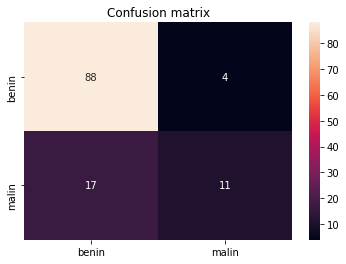

In [81]:
CM = sklearn.metrics.confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()